In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [2]:
pd.set_option('display.max_columns', 50)

def clear_cols(s):
    return s.strip().replace(" ","_")

In [3]:
inpatient_path   = '../Healthcare Provider Fraud Detection Analysis/Train_Inpatientdata-1542865627584.csv'
outpatient_path  = '../Healthcare Provider Fraud Detection Analysis/Train_Outpatientdata-1542865627584.csv'
train_path       = '../Healthcare Provider Fraud Detection Analysis/Train-1542865627584.csv'
beneficiary_path = '../Healthcare Provider Fraud Detection Analysis/Train_Beneficiarydata-1542865627584.csv'

# read inpatient outpatient and train files data
inpatient  = pd.read_csv(inpatient_path).rename(columns=clear_cols)
outpatient = pd.read_csv(outpatient_path).rename(columns=clear_cols)
train       = pd.read_csv(train_path).rename(columns=clear_cols)
bene       = pd.read_csv(beneficiary_path).rename(columns=clear_cols)

In [4]:
most_and_least = inpatient.groupby('Provider')[['BeneID']].count().reset_index().rename(columns={'BeneID': 'count_bene'})

In [5]:
df = most_and_least.merge(train, on='Provider', how='left')
df

,Provider,count_bene,PotentialFraud
0,PRV51001,5,No
1,PRV51003,62,Yes
2,PRV51007,3,No
3,PRV51008,2,No
4,PRV51011,1,No
...,...,...,...
2087,PRV57719,4,No
2088,PRV57728,1,No
2089,PRV57729,11,No
2090,PRV57732,11,No


In [7]:
X = df[['count_bene']]
X

,count_bene
0,5
1,62
2,3
3,2
4,1
...,...
2087,4
2088,1
2089,11
2090,11


In [8]:
y = (df.PotentialFraud == 'Yes').astype(int)
y

0       0
1       1
2       0
3       0
4       0
       ..
2087    0
2088    0
2089    0
2090    0
2091    0
Name: PotentialFraud, Length: 2092, dtype: int64

In [9]:
y.value_counts()  # 1 == YES (Fraud)

PotentialFraud
0    1652
1     440
Name: count, dtype: int64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=42)


In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [13]:
y_pred = model.predict(X_test)
# y_pred

In [14]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy fraud based on number of bene/ inpatient: {accuracy:.2f}")

Accuracy fraud based on number of bene/ inpatient: 0.83


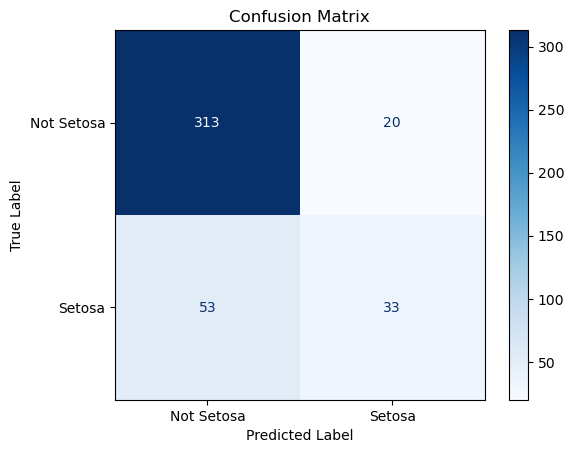

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Setosa', 'Setosa'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [16]:
TN, FP, FN, TP = cm.ravel()

In [17]:
# Calculating metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.83
Precision: 0.62
Recall: 0.38
F1 Score: 0.47


#### I'll try to get better results here:

In [18]:
y_proba = model.predict_proba(X_test)[:, 1]

In [19]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

f1_scores = 2* (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[f1_scores.argmax()]

In [20]:
best_threshold

np.float64(0.204261281562125)

In [21]:
y_pred_custom = (y_proba >= best_threshold).astype(int)
cm1 = confusion_matrix(y_test, y_pred_custom)
print(f'Confusion Matrix with best threshold:\n{cm1}')

Confusion Matrix with best threshold:
[[289  44]
 [ 31  55]]


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(f'Accuracy score: {accuracy_score(y_test, y_pred_custom)}')
print(f'Precision score: {precision_score(y_test, y_pred_custom)}')
print(f'Recall score: {recall_score(y_test, y_pred_custom)}')
print(f'F1 score: {f1_score(y_test, y_pred_custom)}')


Accuracy score: 0.8210023866348448
Precision score: 0.5555555555555556
Recall score: 0.6395348837209303
F1 score: 0.5945945945945946


# Calculate the ROC and AUC

In [24]:
roc_df = pd.DataFrame({
    'true_label': y_test.values,
    'pred_prob': y_proba
})

roc_df.tail()

,true_label,pred_prob
414,0,0.075668
415,1,0.214212
416,1,0.110891
417,0,0.084523
418,0,0.075668


In [25]:
# Sort by predicted probability in descending order
roc_df = roc_df.sort_values('pred_prob', ascending=False).reset_index(drop=True)
# Display the first few rows to understand the data
print("Step 1: Sorted predictions by probability")
roc_df.head(10)

Step 1: Sorted predictions by probability


,true_label,pred_prob
0,1,0.999988
1,1,0.999981
2,1,0.999923
3,1,0.999365
4,1,0.999193
5,1,0.999193
6,1,0.995399
7,1,0.987312
8,0,0.984841
9,1,0.977087


In [26]:
# Step 2: Calculate TPR and FPR at each possible threshold
# Initialize columns for counts and rates
roc_df['threshold'] = roc_df['pred_prob']  # Each row's probability becomes a potential threshold
roc_df['TP'] = 0
roc_df['FP'] = 0
roc_df['FN'] = 0
roc_df['TN'] = 0
roc_df['TPR'] = 0.0
roc_df['FPR'] = 0.0

In [28]:
# Calculate actual counts of positives and negatives
n_pos = sum(roc_df['true_label'] == 1)
n_neg = sum(roc_df['true_label'] == 0)
print(f"Total positive examples (fraud = fraud): {n_pos}")
print(f"Total negative examples: {n_neg}")

Total positive examples (fraud = fraud): 86
Total negative examples: 333


In [29]:
# Step 3: For each threshold (row in our sorted df), calculate confusion matrix values
for i in range(len(roc_df)):
    # At this threshold, predictions for indices >= i are positive
    # and predictions for indices < i are negative
    threshold = roc_df.loc[i, 'threshold']
    # Calculate TP, FP, FN, TN for this threshold
    preds = (roc_df['pred_prob'] >= threshold).astype(int)
    TP = sum((preds == 1) & (roc_df['true_label'] == 1))
    FP = sum((preds == 1) & (roc_df['true_label'] == 0))
    FN = sum((preds == 0) & (roc_df['true_label'] == 1))
    TN = sum((preds == 0) & (roc_df['true_label'] == 0))
    # Calculate TPR and FPR
    TPR = TP / n_pos if n_pos > 0 else 0
    FPR = FP / n_neg if n_neg > 0 else 0
    # Store values
    roc_df.loc[i, 'TP'] = TP
    roc_df.loc[i, 'FP'] = FP
    roc_df.loc[i, 'FN'] = FN
    roc_df.loc[i, 'TN'] = TN
    roc_df.loc[i, 'TPR'] = TPR
    roc_df.loc[i, 'FPR'] = FPR

In [30]:
roc_df

,true_label,pred_prob,threshold,TP,FP,FN,TN,TPR,FPR
0,1,0.999988,0.999988,1,0,85,333,0.011628,0.0
1,1,0.999981,0.999981,2,0,84,333,0.023256,0.0
2,1,0.999923,0.999923,3,0,83,333,0.034884,0.0
3,1,0.999365,0.999365,4,0,82,333,0.046512,0.0
4,1,0.999193,0.999193,6,0,80,333,0.069767,0.0
...,...,...,...,...,...,...,...,...,...
414,0,0.075668,0.075668,86,333,0,0,1.000000,1.0
415,0,0.075668,0.075668,86,333,0,0,1.000000,1.0
416,0,0.075668,0.075668,86,333,0,0,1.000000,1.0
417,0,0.075668,0.075668,86,333,0,0,1.000000,1.0


In [31]:
# Step 4: Add the (0,0) point explicitly for plotting
roc_points = roc_df[['FPR', 'TPR']].copy()
roc_points.head(5)

,FPR,TPR
0,0.0,0.011628
1,0.0,0.023256
2,0.0,0.034884
3,0.0,0.046512
4,0.0,0.069767


In [32]:
# Add the (0,0) point - when threshold > max probability
roc_points.loc[-1] = [0, 0]
roc_points

,FPR,TPR
0,0.0,0.011628
1,0.0,0.023256
2,0.0,0.034884
3,0.0,0.046512
4,0.0,0.069767
...,...,...
415,1.0,1.000000
416,1.0,1.000000
417,1.0,1.000000
418,1.0,1.000000


In [33]:
roc_points = roc_points.sort_index().reset_index(drop=True)
roc_points

,FPR,TPR
0,0.0,0.000000
1,0.0,0.011628
2,0.0,0.023256
3,0.0,0.034884
4,0.0,0.046512
...,...,...
415,1.0,1.000000
416,1.0,1.000000
417,1.0,1.000000
418,1.0,1.000000


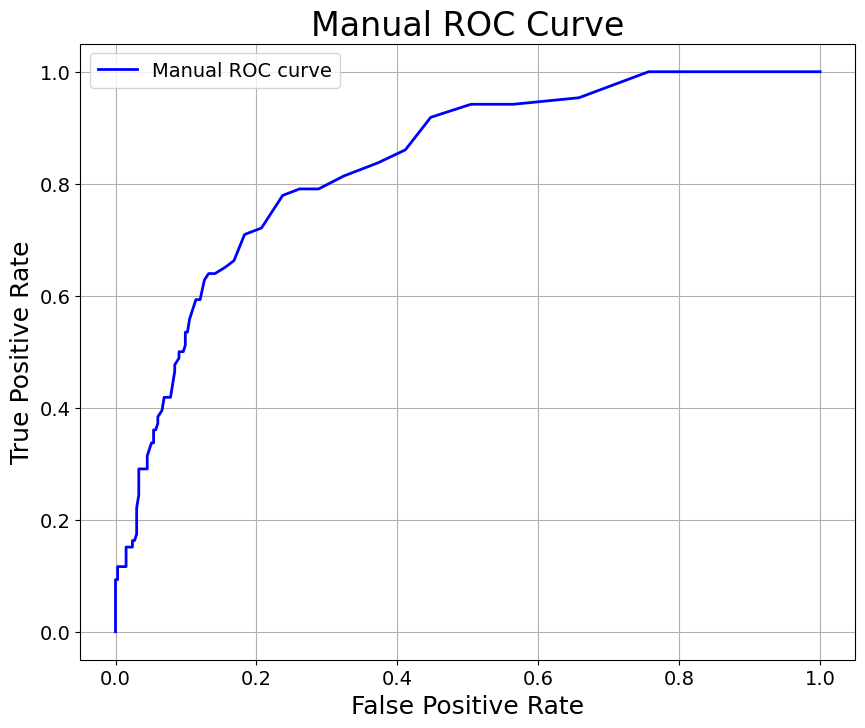

In [34]:
# Step 5: Plot the manually calculated ROC curve
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(roc_points['FPR'], roc_points['TPR'], 'b-', lw=2, label='Manual ROC curve')
# Set title with larger font size
ax.set_title('Manual ROC Curve', fontsize=24)
# Set axis labels with custom font sizes
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.set_ylabel('True Positive Rate', fontsize=18)
# Set tick label sizes
ax.tick_params(axis='both', which='major', labelsize=14)
# Set legend font size
ax.legend(fontsize=14)
ax.grid(True)
plt.show()

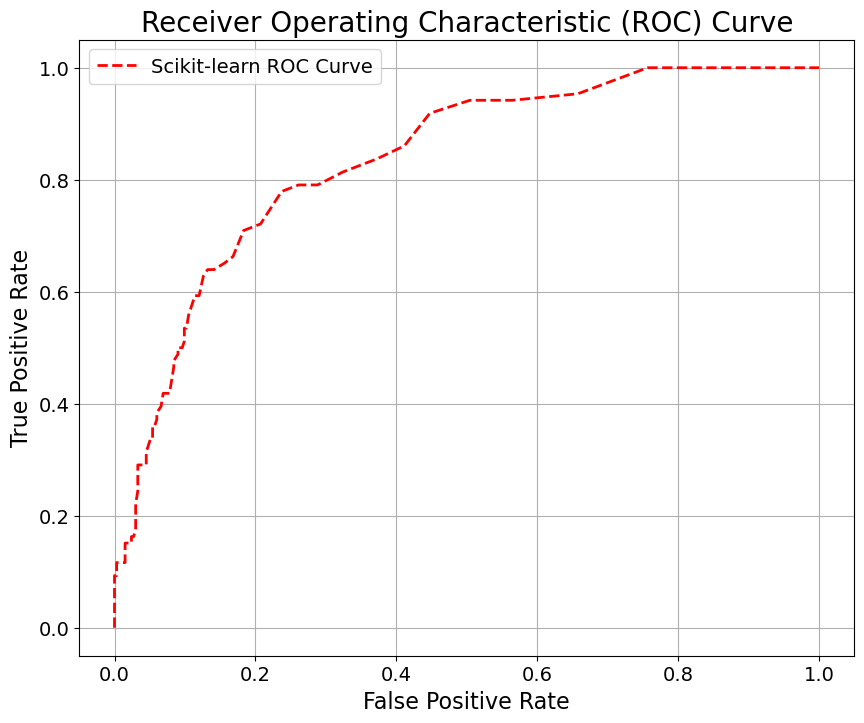

In [35]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [36]:
from sklearn.metrics import auc
auc(fpr, tpr)

np.float64(0.8354982889866611)